| Etapa                      | Tecnologia recomendada                              | Justificativa                                           |
| -------------------------- | --------------------------------------------------- | ------------------------------------------------------- |
| Orquestração mensal        | `cron` no App Service ou Azure Functions            | Automação simples                                       |
| Ambiente isolado           | Docker                                              | Facilita dependências (`duckdb`, `pandas`, `azure-sdk`) |
| Extração + Upload Bronze   | Python puro (`requests`, `zipfile`, `DataLake SDK`) | Você já faz isso bem                                    |
| Transformações Silver/Gold | `Pandas` ou `DuckDB`                                | Leves, simples, ideais para CSV                         |
| Deploy                     | Azure App Service + GitHub Actions                  | CI/CD automatizado                                      |


cnes-data-pipeline/
│
├── Dockerfile
├── requirements.txt
├── app.py                  ← ponto de entrada principal
├── extract/
│   └── extract_cnes.py     ← download e bronze upload
├── transform/
│   ├── silver.py           ← limpeza e joins
│   └── gold.py             ← agregações e finais
├── utils/
│   └── azure_datalake.py   ← funções para leitura/escrita
└── cron/
    └── crontab.txt         ← para rodar mensalmente no container


# Conexão com o Datalake

In [134]:
from azure.storage.filedatalake import DataLakeServiceClient
from io import BytesIO
import os
import pandas as pd

# =========================
# Conexão
# =========================
ACCOUNT_NAME = "cnesstorage"
ACCOUNT_KEY  = os.getenv("AZURE_STORAGE_KEY", "/ae47eZuE0NGPopxVHEkxOKsQwtEm3qQM0vBRPBRbB5nAW1zO6FPkEO9gwNQwkqExaVhOyHWgb68+AStIau+Uw==")
FILE_SYSTEM  = "gold"

service_client = DataLakeServiceClient(
    account_url=f"https://{ACCOUNT_NAME}.dfs.core.windows.net",
    credential=ACCOUNT_KEY,
)
fs = service_client.get_file_system_client(FILE_SYSTEM)


def read_from_adls(
    fs_client,
    path: str,
    file_type: str | None = None,
    **kwargs
) -> pd.DataFrame:
    """
    Lê um arquivo do ADLS em memória e carrega em um DataFrame Pandas.

    Params:
      fs_client : FileSystemClient do ADLS
      path      : caminho no container (ex: 'estabelecimentos_202501.parquet')
      file_type : 'parquet' | 'csv' | 'json' | None (quando None, infere pela extensão)
      **kwargs  : repassados ao reader correspondente (sep, encoding, dtype, nrows, etc.)

    Ex.: read_from_adls(fs, "dados.parquet")
         read_from_adls(fs, "dados.csv", sep=";", encoding="utf-8")
         read_from_adls(fs, "dados.json", lines=True)
    """
    # Inferência simples pela extensão, caso não venha file_type
    if file_type is None:
        lower = path.lower()
        if lower.endswith(".parquet"):
            file_type = "parquet"
        elif lower.endswith(".csv"):
            file_type = "csv"
        elif lower.endswith(".json"):
            file_type = "json"
        else:
            raise ValueError("Cannot infer file_type from extension. Pass file_type explicitly.")

    file_client = fs_client.get_file_client(path)
    data = file_client.download_file().readall()
    bio = BytesIO(data)

    if file_type == "parquet":
        return pd.read_parquet(bio, **kwargs)
    elif file_type == "csv":
        return pd.read_csv(bio, **kwargs)
    elif file_type == "json":
        return pd.read_json(bio, **kwargs)
    else:
        raise ValueError(f"Unsupported file_type: {file_type!r}. Use 'parquet', 'csv' or 'json'.")


# df_populacao = read_from_adls(fs, "populacao/populacao_sp/data.parquet", file_type="parquet")
# df_estabelecimentos = read_from_adls(fs, "estabelecimentos/estabelecimentos_sp_metricas/data.parquet", file_type="parquet")
df_estabelecimentos = pd.read_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas.csv")
df_populacao = pd.read_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/populacao_sp.csv")
df_estabelecimentos

,CO_MUNICIPIO_SEM_DIGITO,YYYY,MM,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000
0,350280,2022,1,ARACATUBA,MEDICO PEDIATRA,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,351870,2022,1,GUARUJA,MEDICO GINECOLOGISTA E OBSTETRA,63,35.0,São Paulo,São Paulo,GUARUJA,314651.0,314651.0,-864.0,-0.002738,0.200222
2,351515,2022,2,ENGENHEIRO COELHO,MEDICO CLINICO,45,35.0,São Paulo,Campinas,ENGENHEIRO COELHO,21129.0,21174.0,-45.0,-0.002125,2.129774
3,352940,2022,2,MAUA,MEDICO ANESTESIOLOGISTA,34,35.0,São Paulo,São Paulo,MAUA,462097.0,463604.0,-1507.0,-0.003251,0.073578
4,353750,2022,2,PEREIRAS,MEDICO CLINICO,15,35.0,São Paulo,Sorocaba,PEREIRAS,8909.0,8906.0,3.0,0.000337,1.683691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377125,352800,2024,11,MACATUBA,MEDICO ORTOPEDISTA E TRAUMATOLOGISTA,2,35.0,São Paulo,Bauru,MACATUBA,17137.0,17120.0,2.0,0.000117,0.116707
377126,354780,2025,1,SANTO ANDRE,MEDICO RADIOLOGISTA INTERVENCIONISTA,1,35.0,São Paulo,São Paulo,SANTO ANDRE,782048.0,782048.0,283.0,0.000362,0.001279
377127,350860,2025,1,CACHOEIRA PAULISTA,MEDICO UROLOGISTA,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377128,353810,2025,1,PINDORAMA,MEDICO PSIQUIATRA,1,35.0,São Paulo,São José do Rio Preto,PINDORAMA,14704.0,14704.0,-1.0,-0.000068,0.068009


## Plot Functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_prof_per_1k_over_time(df_final: pd.DataFrame, city: str):
    # cria coluna de data
    df = df_final.copy()
    df["date"] = pd.to_datetime(df["YYYY"].astype(str) + "-" + df["MM"].astype(str).str.zfill(2) + "-01")

    # filtra cidade
    df = df[df["NO_MUNICIPIO"].str.upper().str.strip() == city.upper().strip()]
    if df.empty:
        print(f"Sem dados para {city}.")
        return

    # pivot: linhas = data, colunas = especialidade, valores = profissionais por 1000
    pivot = (
        df.pivot_table(
            index="date",
            columns="DS_ATIVIDADE_PROFISSIONAL",
            values="PROFISSIONAIS_POR_1000",
            aggfunc="mean"
        )
        .sort_index()
    )

    # plota
    ax = pivot.plot(figsize=(12, 6))
    ax.set_title(f"Profissionais por 1.000 hab — {city.upper()}")
    ax.set_xlabel("Data")
    ax.set_ylabel("Profissionais por 1.000")
    ax.legend(title="Especialidade", ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_population_over_time(df: pd.DataFrame, city: str, *, city_col="NO_MUNICIPIO"):
    d = df.copy()

    # build monthly date safely
    d["YYYY"] = pd.to_numeric(d["YYYY"], errors="coerce").astype("Int64")
    d["MM"]   = pd.to_numeric(d["MM"],   errors="coerce").astype("Int64")
    d = d.dropna(subset=["YYYY","MM"])
    d["date"] = pd.to_datetime(
        d["YYYY"].astype(int).astype(str) + "-" +
        d["MM"].astype(int).astype(str).str.zfill(2) + "-01"
    )

    # filter city (case/space-insensitive)
    mask_city = d[city_col].str.upper().str.strip() == city.upper().strip()
    d = d[mask_city]
    if d.empty:
        print(f"Sem dados de população para {city}.")
        return

    # choose the population column
    pop_col = "POPULACAO_MENSAL" if "POPULACAO_MENSAL" in d.columns else "POPULACAO"

    # monthly series: if multiple rows per month, take the max (avoids duplicates by especialidade)
    pop_mensal = (
        d.groupby("date")[pop_col]
         .max()
         .sort_index()
    )

    # plot
    ax = pop_mensal.plot(figsize=(12, 4))
    ax.set_title(f"População — {city.upper()}")
    ax.set_xlabel("Data")
    ax.set_ylabel("População")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


from typing import Optional

def plot_city_prof1k_and_population(
    df: pd.DataFrame,
    city: str,
    *,
    city_col: str = "NO_MUNICIPIO",
    year_col: str = "YYYY",
    month_col: str = "MM",
    date_col: str = "date",
    specialty_col: str = "DS_ATIVIDADE_PROFISSIONAL",
    idx_col: str = "PROFISSIONAIS_POR_1000",
    pop_monthly_col: str = "POPULACAO_MENSAL",
    pop_yearly_col: str = "POPULACAO",
    top_n_specialties: Optional[int] = None,  # e.g. 6 to keep legend short
    fig_w: float = 16,
    fig_h: float = 5,
    legend_fontsize: int = 8,
    legend_title: str = "Especialidade",
    xtick_rotation: int = 30
) -> None:
    """
    Plots two side-by-side charts for a city:
      - Left: Profissionais por 1.000 hab (one line per specialty; legend outside)
      - Right: População mensal

    If POPULACAO_MENSAL is not present, falls back to POPULACAO (yearly) and takes max per month.
    Set top_n_specialties to limit the number of lines (by highest mean value).
    """

    d = df.copy()

    # Build monthly date safely
    if date_col not in d.columns:
        d[year_col]  = pd.to_numeric(d[year_col],  errors="coerce").astype("Int64")
        d[month_col] = pd.to_numeric(d[month_col], errors="coerce").astype("Int64")
        d = d.dropna(subset=[year_col, month_col])
        d[date_col] = pd.to_datetime(
            d[year_col].astype(int).astype(str) + "-" +
            d[month_col].astype(int).astype(str).str.zfill(2) + "-01"
        )

    # Filter city (case/space-insensitive)
    d = d[d[city_col].str.upper().str.strip() == city.upper().strip()]
    if d.empty:
        print(f"Sem dados para {city}.")
        return

    # Left panel data: pivot index=month date, columns=specialty, values=index
    left_df = (
        d.pivot_table(
            index=date_col,
            columns=specialty_col,
            values=idx_col,
            aggfunc="mean"
        )
        .sort_index()
    )

    # Optionally keep only top-N specialties by mean value (for a cleaner legend)
    if top_n_specialties is not None and top_n_specialties > 0 and not left_df.empty:
        keep_cols = (
            left_df.mean(skipna=True)
                   .sort_values(ascending=False)
                   .head(top_n_specialties)
                   .index
        )
        left_df = left_df[keep_cols]

    # Right panel data: population monthly (or yearly fallback)
    pop_col = pop_monthly_col if pop_monthly_col in d.columns else pop_yearly_col
    right_s = (
        d.groupby(date_col)[pop_col]
         .max()      # avoid duplicates by specialty
         .sort_index()
    )

    # ---- Plot side-by-side with outside legend (left) ----
    fig, axes = plt.subplots(1, 2, figsize=(fig_w, fig_h), constrained_layout=True)

    # Left: index per 1k
    left_lines = left_df.plot(ax=axes[0])  # returns Axes
    axes[0].set_title(f"Profissionais por 1.000 hab — {city.upper()}")
    axes[0].set_xlabel("Data")
    axes[0].set_ylabel("Profissionais por 1.000")
    axes[0].grid(True)

    # Legend outside (to the right of left subplot)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(
        handles, labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        fontsize=legend_fontsize,
        title=legend_title
    )

    # Right: population
    right_s.plot(ax=axes[1])
    axes[1].set_title(f"População — {city.upper()}")
    axes[1].set_xlabel("Data")
    axes[1].set_ylabel("População")
    axes[1].grid(True)

    # Rotate x-ticks for both panels
    for ax in axes:
        ax.tick_params(axis="x", rotation=xtick_rotation)

    plt.show()


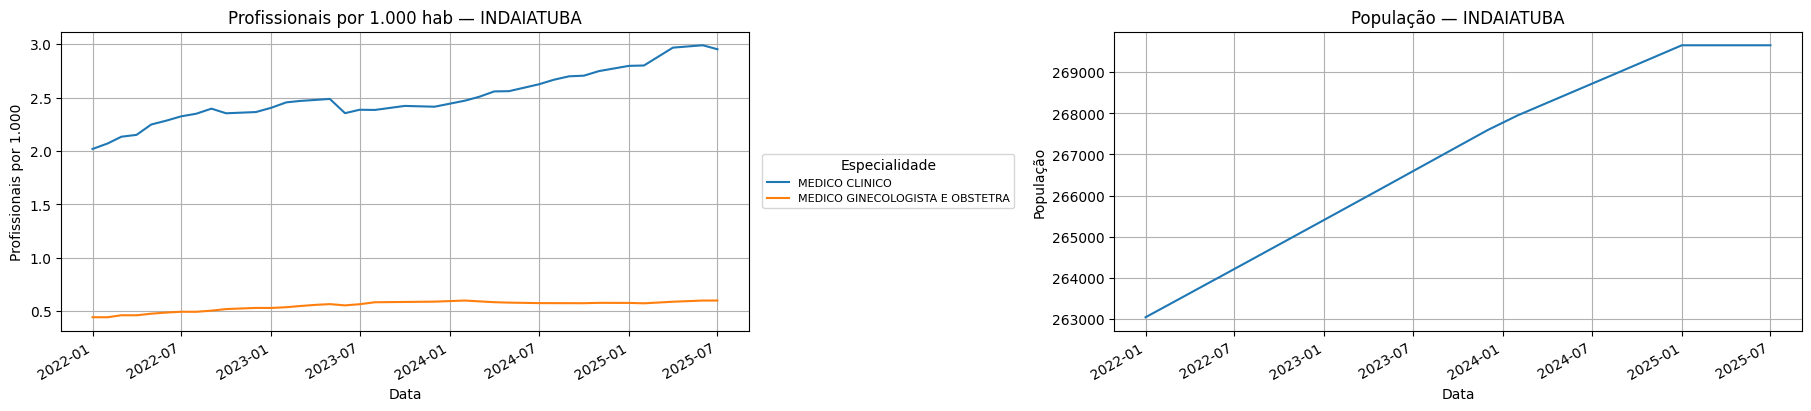

In [135]:
# plot_prof_per_1k_over_time(df_estabelecimentos, city="Sao Carlos")
# plot_population_over_time(df_estabelecimentos, city="Sao Carlos")

plot_city_prof1k_and_population(df_estabelecimentos.query("DS_ATIVIDADE_PROFISSIONAL in ('MEDICO CLINICO', 'MEDICO GINECOLOGISTA E OBSTETRA')"), city="Indaiatuba", fig_w=18, fig_h=4)
# plot_city_prof1k_and_population(df_estabelecimentos.query("DS_ATIVIDADE_PROFISSIONAL in ('MEDICO CLINICO', 'MEDICO GINECOLOGISTA E OBSTETRA')"), city="Sao Carlos", fig_w=18, fig_h=4)


# Análise Descritiva

In [39]:

print("\nValores ausentes:")
print(df_estabelecimentos.isna().sum())


Valores ausentes:
CO_MUNICIPIO_SEM_DIGITO          0
YYYY                             0
MM                               0
NO_MUNICIPIO                     0
DS_ATIVIDADE_PROFISSIONAL        0
TOTAL_PROFISSIONAIS              0
CO_UF                        88156
NO_UF                        88156
NO_REGIAO                    88156
NO_MUNICIPIO_IBGE            88156
POPULACAO_MENSAL             88156
POPULACAO                    88156
GROWTH_ABS                   88156
GROWTH_PCT                   88156
PROFISSIONAIS_POR_1000       88156
dtype: int64


In [136]:

print("\nEstatísticas numéricas:")
df_estabelecimentos.describe()


Estatísticas numéricas:


,CO_MUNICIPIO_SEM_DIGITO,YYYY,MM,TOTAL_PROFISSIONAIS,CO_UF,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000
count,377130.000000,377130.000000,377130.000000,377130.000000,288974.0,2.889740e+05,2.889740e+05,288974.000000,288974.000000,288974.000000
mean,352852.635009,2023.248113,5.835749,19.762119,35.0,2.273981e+05,2.276049e+05,-40.810215,-0.000257,0.287134
std,1694.757564,1.047087,3.218621,179.941015,0.0,1.082191e+06,1.085723e+06,1024.290116,0.009098,6.893303
min,350010.000000,2022.000000,1.000000,1.000000,35.0,4.000000e+00,4.000000e+00,-14283.000000,-0.444444,0.000082
25%,351370.000000,2022.000000,3.000000,1.000000,35.0,1.585375e+04,1.602500e+04,-32.000000,-0.000874,0.026096
50%,352720.000000,2023.000000,6.000000,3.000000,35.0,4.875000e+04,4.872500e+04,0.000000,0.000000,0.073132
75%,354390.000000,2024.000000,8.000000,8.000000,35.0,1.585870e+05,1.578500e+05,24.000000,0.000365,0.203070
max,355730.000000,2025.000000,12.000000,14796.000000,35.0,1.222714e+07,1.222714e+07,5354.000000,0.065724,1500.000000


In [19]:
df_estabelecimentos.groupby("DS_ATIVIDADE_PROFISSIONAL")["DS_ATIVIDADE_PROFISSIONAL"].count().sort_values(ascending=False).head(15)  # pega top 15 (pode mudar para 10 ou 20)


DS_ATIVIDADE_PROFISSIONAL
MEDICO CLINICO                                   35087
MEDICO GINECOLOGISTA E OBSTETRA                  31037
MEDICO PEDIATRA                                  30718
MEDICO PSIQUIATRA                                24773
MEDICO CARDIOLOGISTA                             23522
MEDICO EM RADIOLOGIA E DIAGNOSTICO POR IMAGEM    23104
MEDICO ORTOPEDISTA E TRAUMATOLOGISTA             22735
MEDICO DA ESTRATEGIA DE SAUDE DA FAMILIA         22058
MEDICO OFTALMOLOGISTA                            20210
MEDICO CIRURGIAO GERAL                           17583
MEDICO NEUROLOGISTA                              16929
MEDICO DERMATOLOGISTA                            16891
MEDICO UROLOGISTA                                16117
MEDICO OTORRINOLARINGOLOGISTA                    15651
MEDICO ANESTESIOLOGISTA                          14914
Name: DS_ATIVIDADE_PROFISSIONAL, dtype: int64

In [20]:
# df_estabelecimentos.query("PROFISSIONAIS_POR_1000 >= 1000") # NO_MUNICIPIO = JERIQUARA
df_estabelecimentos.query("PROFISSIONAIS_POR_1000 >= 10") # NO_MUNICIPIO = JERIQUARA
# df_estabelecimentos.query("TOTAL_PROFISSIONAIS >= 14000") # NO_MUNICIPIO = SAO PAULO	


,CO_MUNICIPIO_SEM_DIGITO,YYYY,MM,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,TP_SUS_NAO_SUS,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000
7519,351495,2023,2,EMBAUBA,MEDICO CLINICO,S,36,35.0,São Paulo,São José do Rio Preto,EMBAUBA,2381.0,2384.0,-3.0,-0.001258,15.119698
8282,354430,2024,5,ROSEIRA,MEDICO CLINICO,S,133,35.0,São Paulo,São José dos Campos,ROSEIRA,11109.0,11095.0,4.0,0.000360,11.972275
8528,353570,2024,9,PARAISO,MEDICO CLINICO,S,106,35.0,São Paulo,São José do Rio Preto,PARAISO,6216.0,6211.0,1.0,0.000161,17.052767
11083,351495,2025,2,EMBAUBA,MEDICO CLINICO,S,32,35.0,São Paulo,São José do Rio Preto,EMBAUBA,2349.0,2349.0,0.0,0.000000,13.622818
11329,352540,2025,7,JERIQUARA,MEDICO PSIQUIATRA,S,2,35.0,São Paulo,Ribeirão Preto,JERIQUARA,4.0,4.0,0.0,0.000000,500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985668,351495,2025,4,EMBAUBA,MEDICO CLINICO,S,35,35.0,São Paulo,São José do Rio Preto,EMBAUBA,2349.0,2349.0,0.0,0.000000,14.899957
2035931,352540,2025,2,JERIQUARA,MEDICO CARDIOLOGISTA,S,1,35.0,São Paulo,Ribeirão Preto,JERIQUARA,4.0,4.0,0.0,0.000000,250.000000
2042264,352540,2024,8,JERIQUARA,MEDICO PEDIATRA,S,1,35.0,São Paulo,Ribeirão Preto,JERIQUARA,72.0,3976.0,-57.0,-0.441860,13.888889
2048033,352540,2024,7,JERIQUARA,MEDICO CLINICO,S,5,35.0,São Paulo,Ribeirão Preto,JERIQUARA,129.0,3976.0,-97.0,-0.429204,38.759690


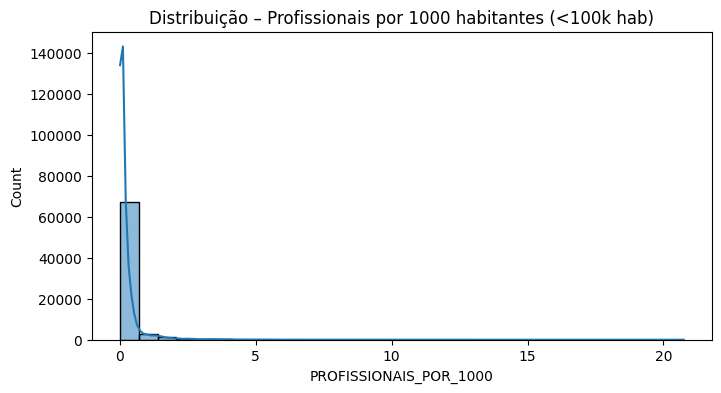

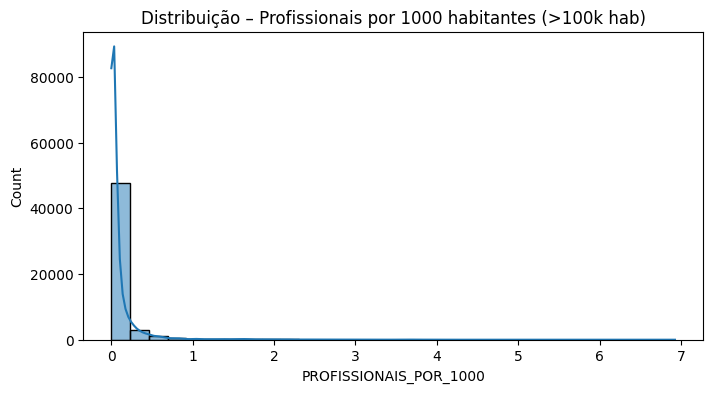

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps

query_mais_100k = """
SELECT *
FROM df_estabelecimentos
WHERE PROFISSIONAIS_POR_1000 IS NOT NULL
AND NO_MUNICIPIO NOT IN ('SAO PAULO', 'JERIQUARA')
AND POPULACAO > 100000
AND GROWTH_PCT > 0
"""
query_menos_100k = """
SELECT *
FROM df_estabelecimentos
WHERE PROFISSIONAIS_POR_1000 IS NOT NULL
AND NO_MUNICIPIO NOT IN ('SAO PAULO', 'JERIQUARA')
AND POPULACAO < 100000
AND GROWTH_PCT > 0
"""
df_to_explore_mais_100k = ps.sqldf(query_mais_100k, locals())
df_to_explore_mais_100k["YYYYMM"] = pd.to_datetime(df_to_explore_mais_100k["YYYY"].astype(str)+ df_to_explore_mais_100k["MM"].astype(str).str.zfill(2),format="%Y%m")

df_to_explore_menos_100k = ps.sqldf(query_menos_100k, locals())
df_to_explore_menos_100k['YYYYMM'] = pd.to_datetime(df_to_explore_menos_100k["YYYY"].astype(str) + df_to_explore_menos_100k["MM"].astype(str).str.zfill(2),format="%Y%m")


# Histograma de profissionais por 1000
plt.figure(figsize=(8,4))
sns.histplot(df_to_explore_menos_100k["PROFISSIONAIS_POR_1000"], bins=30, kde=True)
plt.title("Distribuição – Profissionais por 1000 habitantes (<100k hab)")
plt.show()


plt.figure(figsize=(8,4))
sns.histplot(df_to_explore_mais_100k["PROFISSIONAIS_POR_1000"], bins=30, kde=True)
plt.title("Distribuição – Profissionais por 1000 habitantes (>100k hab)")
plt.show()

In [152]:
df_to_explore_mais_100k.to_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas_acima_100k.csv", index=False)
df_to_explore_menos_100k.to_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas_abaixo_100k.csv", index=False)


In [161]:
df_to_explore_mais_100k[["YYYYMM"]].drop_duplicates()

,YYYYMM
0,2022-01-01
2,2022-02-01
10,2022-03-01
11,2022-04-01
24,2022-06-01
27,2022-05-01
35,2022-08-01
36,2022-07-01
37,2022-09-01
39,2022-10-01


In [167]:


city_list = df_to_explore_mais_100k[["NO_MUNICIPIO","YYYYMM"]].drop_duplicates()
city_list = city_list.groupby("NO_MUNICIPIO")["YYYYMM"].agg(["count","min","max"]).reset_index()
city_list

,NO_MUNICIPIO,count,min,max
0,EMBU DAS ARTES,10,2024-02-01,2025-01-01
1,FERRAZ DE VASCONCELOS,10,2024-02-01,2025-01-01
2,FRANCA,31,2022-01-01,2025-01-01
3,FRANCISCO MORATO,10,2024-02-01,2025-01-01
4,FRANCO DA ROCHA,10,2024-02-01,2025-01-01
5,GUARATINGUETA,10,2024-02-01,2025-01-01
6,GUARULHOS,10,2024-02-01,2025-01-01
7,HORTOLANDIA,31,2022-01-01,2025-01-01
8,INDAIATUBA,31,2022-01-01,2025-01-01
9,ITANHAEM,31,2022-01-01,2025-01-01


Top cidades (média profissionais/1000 hab.):


NO_MUNICIPIO_IBGE
JAU                      0.156176
SAO CAETANO DO SUL       0.148120
SANTANA DE PARNAIBA      0.143812
FRANCO DA ROCHA          0.137704
VOTUPORANGA              0.134024
VALINHOS                 0.133947
PINDAMONHANGABA          0.131002
FRANCISCO MORATO         0.128358
SAO JOSE DO RIO PRETO    0.128321
PAULINIA                 0.126993
TABOAO DA SERRA          0.119525
SOROCABA                 0.112141
FERRAZ DE VASCONCELOS    0.110114
SAO CARLOS               0.106840
LIMEIRA                  0.106375
Name: PROFISSIONAIS_POR_1000, dtype: float64

/var/folders/q4/r947g97d1mdblr_m7b44wpfc0000gp/T/ipykernel_77591/3301762047.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")


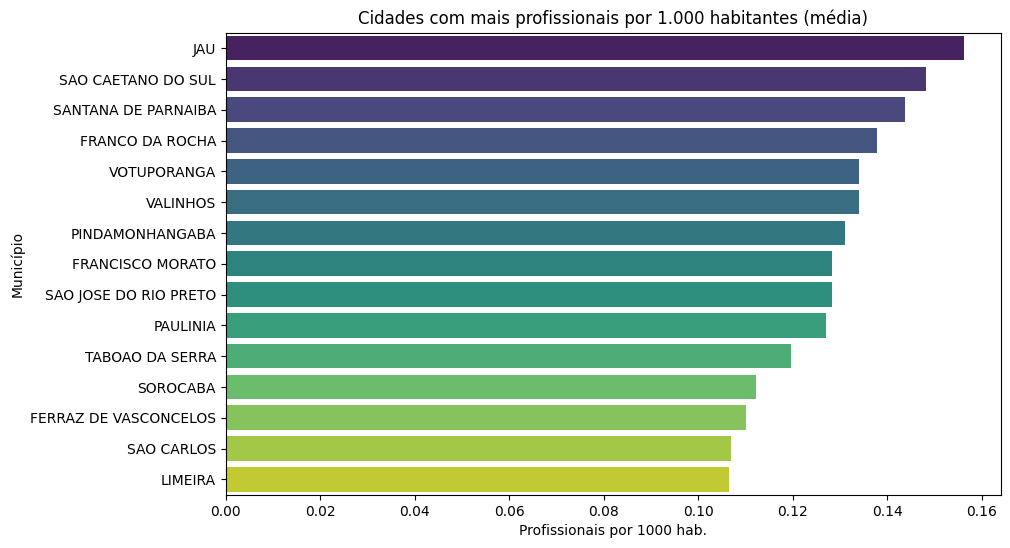

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# Ranking – Cidades com mais profissionais por 1000 hab.
# ======================================================

# Calcula a média por município
top_cities = (
    df_to_explore_mais_100k.groupby("NO_MUNICIPIO_IBGE")["PROFISSIONAIS_POR_1000"]
    .mean()
    .sort_values(ascending=False)
    .head(15)  # pega top 15 (pode mudar para 10 ou 20)
)

# Mostra em tabela
print("Top cidades (média profissionais/1000 hab.):")
display(top_cities)

# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")
plt.title("Cidades com mais profissionais por 1.000 habitantes (média)")
plt.xlabel("Profissionais por 1000 hab.")
plt.ylabel("Município")
plt.show()


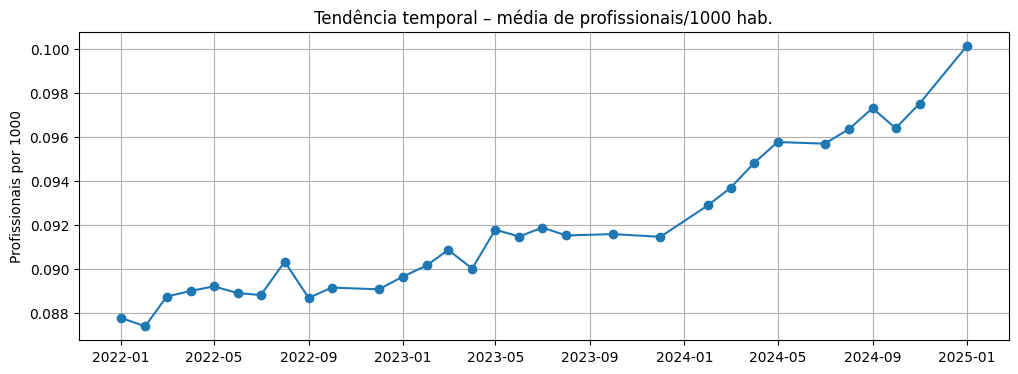

In [142]:
# Série temporal agregada por mês (média geral)
ts = df_to_explore_mais_100k.groupby("YYYYMM")["PROFISSIONAIS_POR_1000"].mean()

plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, marker="o")
plt.title("Tendência temporal – média de profissionais/1000 hab.")
plt.ylabel("Profissionais por 1000")
plt.grid(True)
plt.show()


In [84]:
df_to_plot = df_to_explore.query("POPULACAO <= 100000")

print("Linhas após filtro:", df_to_plot.shape[0])
print(df_to_plot[["POPULACAO","GROWTH_PCT","TOTAL_PROFISSIONAIS","PROFISSIONAIS_POR_1000"]].head())


Linhas após filtro: 0
Empty DataFrame
Columns: [POPULACAO, GROWTH_PCT, TOTAL_PROFISSIONAIS, PROFISSIONAIS_POR_1000]
Index: []


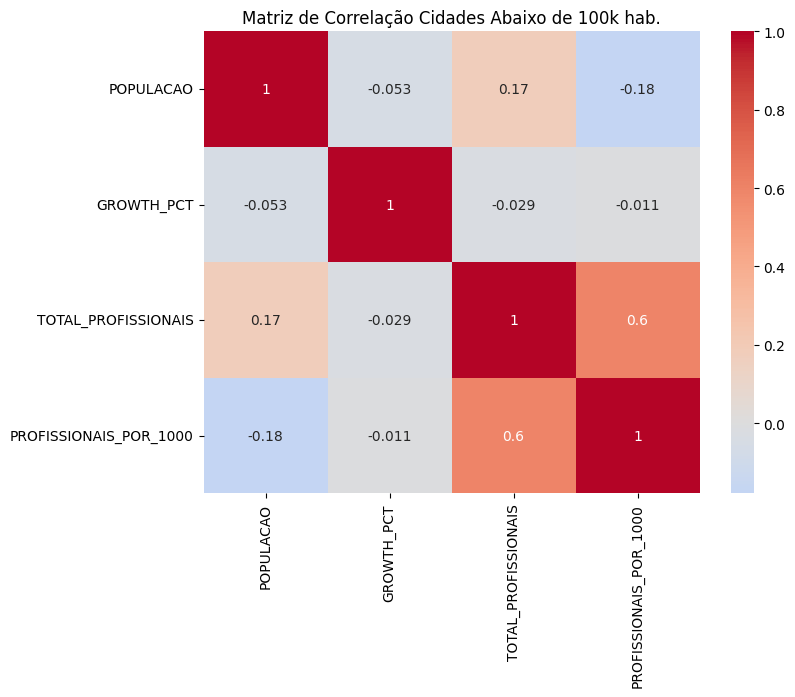

In [143]:
# Matriz correlação entre variáveis
df_menos_100k = df_estabelecimentos.query("NO_MUNICIPIO != ('SAO PAULO', 'JERIQUARA') and POPULACAO < 100000 and GROWTH_PCT > 0")

plt.figure(figsize=(8,6))
sns.heatmap(
    df_menos_100k[["POPULACAO","GROWTH_PCT","TOTAL_PROFISSIONAIS","PROFISSIONAIS_POR_1000"]].corr(),
    annot=True, cmap="coolwarm", center=0
)
plt.title("Matriz de Correlação Cidades Abaixo de 100k hab.")
plt.show()


In [ ]:
import numpy as np

# filtro + CÓPIA (evita SettingWithCopy) e ordenação temporal por grupo
df_mais_100k = (
    df_estabelecimentos
      .query("NO_MUNICIPIO not in ['SAO PAULO','JERIQUARA'] and POPULACAO >= 100000 and GROWTH_PCT > 0")
      .sort_values(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL","YYYY","MM"])
      .copy()
)

grp = ["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]

# --- componentes sazonais (ok) ---
df_mais_100k["mes_sin"] = np.sin(2*np.pi*df_mais_100k["MM"]/12)
df_mais_100k["mes_cos"] = np.cos(2*np.pi*df_mais_100k["MM"]/12)

# --- lags (sem vazamento) ---
df_mais_100k["lag1"] = df_mais_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(1)
df_mais_100k["lag2"] = df_mais_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(2)
df_mais_100k["lag3"] = df_mais_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(3)

# --- diferença mês a mês ---
df_mais_100k["diff1"] = df_mais_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].diff(1)

# --- média móvel 6 meses usando APENAS passado (shift antes do rolling) ---
df_mais_100k["rolling6"] = (
    df_mais_100k
      .groupby(grp)["PROFISSIONAIS_POR_1000"]
      .transform(lambda s: s.shift(1).rolling(6, min_periods=6).mean())
)

# --- interação (atenção: costuma ser redundante com GROWTH_ABS) ---
df_mais_100k["pop_growth_interaction"] = df_mais_100k["POPULACAO_MENSAL"] * df_mais_100k["GROWTH_PCT"]

df_mais_100k
# df_mais_100k.to_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas_acima_100k.csv", index=False)


,CO_MUNICIPIO_SEM_DIGITO,YYYY,MM,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,...,GROWTH_PCT,PROFISSIONAIS_POR_1000,mes_sin,mes_cos,lag1,lag2,lag3,diff1,rolling6,pop_growth_interaction
91122,351500,2024,2,EMBU DAS ARTES,MEDICO ALERGISTA E IMUNOLOGISTA,1,35.0,São Paulo,São Paulo,EMBU DAS ARTES,...,0.000150,0.003856,0.866025,5.000000e-01,NaN,NaN,NaN,NaN,NaN,39.005865
361773,351500,2024,3,EMBU DAS ARTES,MEDICO ALERGISTA E IMUNOLOGISTA,1,35.0,São Paulo,São Paulo,EMBU DAS ARTES,...,0.000143,0.003855,1.000000,6.123234e-17,0.003856,NaN,NaN,-5.499549e-07,NaN,37.005278
87306,351500,2024,4,EMBU DAS ARTES,MEDICO ALERGISTA E IMUNOLOGISTA,1,35.0,São Paulo,São Paulo,EMBU DAS ARTES,...,0.000154,0.003854,0.866025,-5.000000e-01,0.003855,0.003856,NaN,-5.943694e-07,NaN,40.006168
3025,351500,2024,5,EMBU DAS ARTES,MEDICO ALERGISTA E IMUNOLOGISTA,1,35.0,São Paulo,São Paulo,EMBU DAS ARTES,...,0.000146,0.003854,0.500000,-8.660254e-01,0.003854,0.003855,0.003856,-5.644812e-07,NaN,38.005566
155976,351500,2024,7,EMBU DAS ARTES,MEDICO ALERGISTA E IMUNOLOGISTA,1,35.0,São Paulo,São Paulo,EMBU DAS ARTES,...,0.000146,0.003853,-0.500000,-8.660254e-01,0.003854,0.003854,0.003855,-1.143310e-06,NaN,38.005564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140081,355710,2024,8,VOTUPORANGA,MEDICO VETERINARIO,3,35.0,São Paulo,São José do Rio Preto,VOTUPORANGA,...,0.000349,0.029881,-0.866025,-5.000000e-01,0.029892,0.029912,0.029922,-1.042076e-05,NaN,35.012206
355524,355710,2024,9,VOTUPORANGA,MEDICO VETERINARIO,3,35.0,São Paulo,São José do Rio Preto,VOTUPORANGA,...,0.000339,0.029871,-1.000000,-1.836970e-16,0.029881,0.029892,0.029912,-1.011607e-05,0.029914,34.011514
33125,355710,2024,10,VOTUPORANGA,MEDICO VETERINARIO,3,35.0,São Paulo,São José do Rio Preto,VOTUPORANGA,...,0.000339,0.029861,-0.866025,5.000000e-01,0.029871,0.029881,0.029892,-1.010922e-05,0.029902,34.011510
139122,355710,2024,11,VOTUPORANGA,MEDICO VETERINARIO,3,35.0,São Paulo,São José do Rio Preto,VOTUPORANGA,...,0.000348,0.029851,-0.500000,8.660254e-01,0.029861,0.029871,0.029881,-1.039940e-05,0.029890,35.012193


In [168]:
import numpy as np

# filtro + CÓPIA (evita SettingWithCopy) e ordenação temporal por grupo
df_menos_100k = (
    df_estabelecimentos
      .query("NO_MUNICIPIO not in ['SAO PAULO','JERIQUARA'] and POPULACAO < 100000 and GROWTH_PCT > 0")
      .sort_values(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL","YYYY","MM"])
      .copy()
)

grp = ["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]

# --- componentes sazonais (ok) ---
df_menos_100k["mes_sin"] = np.sin(2*np.pi*df_menos_100k["MM"]/12)
df_menos_100k["mes_cos"] = np.cos(2*np.pi*df_menos_100k["MM"]/12)

# --- lags (sem vazamento) ---
df_menos_100k["lag1"] = df_menos_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(1)
df_menos_100k["lag2"] = df_menos_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(2)
df_menos_100k["lag3"] = df_menos_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(3)

# --- diferença mês a mês ---
df_menos_100k["diff1"] = df_menos_100k.groupby(grp)["PROFISSIONAIS_POR_1000"].diff(1)

# --- média móvel 6 meses usando APENAS passado (shift antes do rolling) ---
df_menos_100k["rolling6"] = (
    df_menos_100k
      .groupby(grp)["PROFISSIONAIS_POR_1000"]
      .transform(lambda s: s.shift(1).rolling(6, min_periods=6).mean())
)

# --- interação (atenção: costuma ser redundante com GROWTH_ABS) ---
df_menos_100k["pop_growth_interaction"] = df_menos_100k["POPULACAO_MENSAL"] * df_menos_100k["GROWTH_PCT"]

# df_menos_100k
# df_mais_100k.to_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas_acima_100k.csv", index=False)

df_menos_100k.to_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/estabelecimentos_sp_metricas_abaixo_100k.csv", index=False)

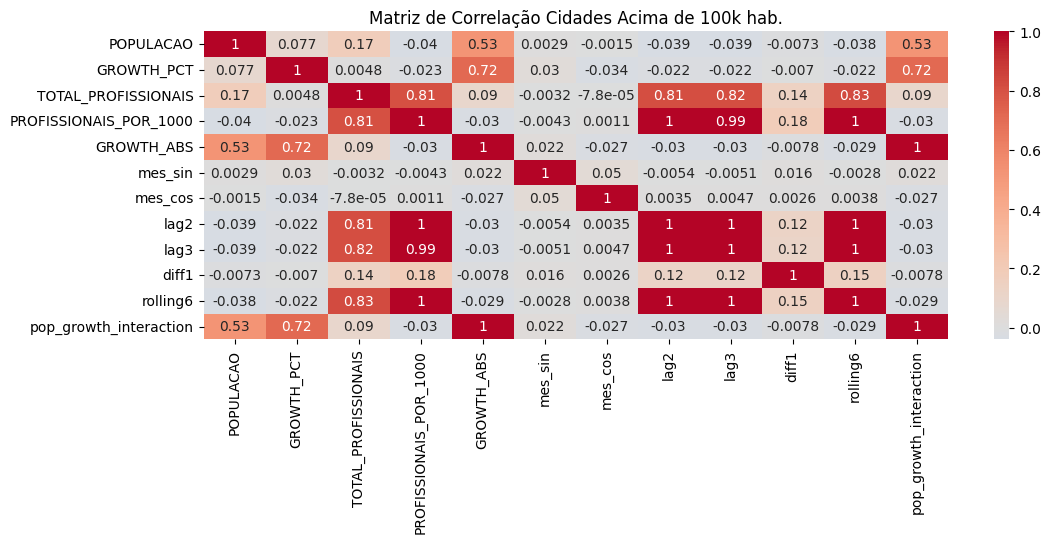

In [145]:



plt.figure(figsize=(12,4))
sns.heatmap(
    df_mais_100k[["POPULACAO","GROWTH_PCT","TOTAL_PROFISSIONAIS","PROFISSIONAIS_POR_1000","GROWTH_ABS","mes_sin","mes_cos","lag2","lag3","diff1","rolling6","pop_growth_interaction"]].corr(),
    annot=True, cmap="coolwarm", center=0
)
plt.title("Matriz de Correlação Cidades Acima de 100k hab.")
plt.show()


# Acima de 100K (LightGBM)
# Resumo do estudo — previsão de “falta de profissionais por mil”

## Por que começamos pela matriz de correlação
- Forte **persistência temporal** de `PROFISSIONAIS_POR_1000` (correlações ≈1 com `lag3` e `rolling6`): o **passado recente explica muito do futuro**.  
- **Sazonalidade linear fraca**: `mes_sin` e `mes_cos` ~ 0.  
- **Redundâncias**: `GROWTH_ABS` ≈ `pop_growth_interaction` e ambos correlacionam com `POPULACAO` → manter **apenas um** para evitar colinearidade.  
- `TOTAL_PROFISSIONAIS` correlaciona com o alvo; usar **apenas defasado** (lags) para não vazar informação do mês corrente.

## Como formulamos o problema
- Objetivo: **alertar** município×profissão que tende a ficar **abaixo de um nível mínimo** de profissionais por mil habitantes no **mês seguinte**.  
- Alvo (classe 1 = “falta”): `target = 1[PROFISSIONAIS_POR_1000(t+1) < Q25]`, onde **Q25** é o **quantil de 25%** do valor futuro.  
  - Antes o corte gerava ~80% de positivos (modelo marcava “tudo”).  
  - Com Q25 a **prevalência** ficou ~19%, mais realista e informativa.

## Modelo escolhido e por quê
- **LightGBM (gradient boosting tabular)**  
  - Captura **relações não lineares** e **interações**.  
  - Trabalha muito bem com **lags** e **médias móveis**.  
  - Treino rápido e interpretável (importâncias/SHAP).  
- **Validação temporal** (últimos 6 meses) e **sem vazamento**:  
  - `lag1/lag2/lag3`, `diff1` e `rolling6` calculados **só com dados até t** (`rolling6` usa `shift(1)`).

## Resultados (validação)
- **ROC-AUC ≈ 0.97** → excelente separação entre “falta” e “ok”.  
- **PR-AUC ≈ 0.84** com prevalência ~0.19 → **grande ganho** sobre o baseline (prevalência).  
- Desempenho por classe (aprox.):  
  - **Classe 1 (falta):** *precision* ~0.76, *recall* ~0.97, *F1* ~0.85.  
  - **Classe 0 (ok):** *precision* ~0.99, *recall* ~0.93, *F1* ~0.96.  
- **Leitura prática:** o modelo **encontra quase todas** as faltas (alto *recall*), com **poucos falsos alarmes** (boa *precision*).

## O que significam as métricas
- **ROC-AUC:** capacidade de **ranquear** positivos vs. negativos para todos os limiares (1.0 = perfeito; 0.5 = aleatório).  
- **PR-AUC:** qualidade das deteções quando positivos são **minoria**; compara *precision*×*recall* em vários limiares (ideal quando custo de falso-negativo é alto).  
- **Precision (Precisão):** entre os alertas emitidos, **quantos eram falta de verdade**.  
- **Recall (Cobertura/Sensibilidade):** entre todas as faltas reais, **quantas o modelo capturou**.  
- **F1-score:** média harmônica entre *precision* e *recall* (equilíbrio dos dois).  
- **Accuracy:** % de acertos gerais (pode enganar em dados desbalanceados).

## Próximos passos recomendados
- **Escolher o limiar operacional** (probabilidade para acionar alerta) pela **curva Precision-Recall**:
  - Opções: maximizar **F1**, impor **recall mínimo** (ex.: ≥95%) ou minimizar **custo esperado** (FN vs. FP).  
- **Baseline** de referência: regra `1[lag1 < threshold]` para monitorar ganho contínuo.  
- **Explainability:** usar importâncias/SHAP para entender drivers (ex.: lags, crescimento populacional).  
- **Produção:** rodar mensalmente com dados até *t*, **monitorar deriva** (prevalência e distribuição das features) e **re-treinar** periodicamente.

> **Em resumo:** a correlação indicou forte dependência temporal; o LightGBM com lags/médias móveis (sem vazamento) modelou bem o comportamento. Com alvo balanceado por **Q25**, o desempenho ficou **muito bom** para uso como **sistema de alerta** de falta de profissionais.


In [147]:
import numpy as np, pandas as pd
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler

THRESH = 1.5  # ajuste seu threshold
grp = ["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]

# 0) ordenar e criar alvo futuro (t+1)
df = df_mais_100k.sort_values(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL","YYYY","MM"]).copy()
df["ds"] = pd.to_datetime(df["YYYY"].astype(int).astype(str) + df["MM"].astype(int).astype(str).str.zfill(2), format="%Y%m")
df["y_next"] = df.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(-1)
thresh_q = 0.5#df["PROFISSIONAIS_POR_1000"].quantile(0.25)  # ajuste p/ 0.2, 0.3 etc.
df["target"] = (df["y_next"] < thresh_q).astype("Int8")

# 1) features (somente info até t; sem vazamento)
features = [
    "lag2","lag3","rolling6","diff1",
    "POPULACAO","GROWTH_PCT",      # escolha um: ou GROWTH_ABS ou pop_growth_interaction
    "mes_sin","mes_cos"
]
# remova redundâncias se existirem nas suas colunas
features = [f for f in features if f in df.columns]

df_model = df.dropna(subset=features + ["target"]).copy()

# 2) split temporal (ex: últimos 6 meses p/ validação)
cut_date = df_model["ds"].max() - pd.offsets.MonthBegin(6)
train = df_model[df_model["ds"] < cut_date]
valid = df_model[df_model["ds"] >= cut_date]

X_tr, y_tr = train[features], train["target"]
X_va, y_va = valid[features], valid["target"]

# 3) weights p/ desbalanceamento (opcional)
pos_weight = (len(y_tr) - y_tr.sum()) / (y_tr.sum() + 1e-9)

params = dict(
    objective="binary",
    metric=["auc","binary_logloss"],
    learning_rate=0.05,
    num_leaves=63,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=1,
    min_data_in_leaf=50,
    scale_pos_weight=float(pos_weight),  # ajuda recall de minoritária
    verbose=-1
)

dtrain = lgb.Dataset(X_tr, label=y_tr)
dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

gbm = lgb.train(
    params, dtrain,
    num_boost_round=3000,
    valid_sets=[dtrain, dvalid],
    valid_names=["train","valid"]
)

# 4) avaliação
p_va = gbm.predict(X_va, num_iteration=gbm.best_iteration)
print("ROC-AUC:", roc_auc_score(y_va, p_va))
print("PR-AUC :", average_precision_score(y_va, p_va))

# threshold operacional (maximize F1/recall conforme sua preferência)
thr = 0.3  # ex.: priorize recall
yhat = (p_va >= thr).astype(int)
print(classification_report(y_va, yhat, digits=3))


ROC-AUC: 0.5093800403679976
PR-AUC : 0.7678432038596579
              precision    recall  f1-score   support

         0.0      0.808     0.186     0.302      2832
         1.0      0.801     0.987     0.884      9405

    accuracy                          0.801     12237
   macro avg      0.804     0.586     0.593     12237
weighted avg      0.803     0.801     0.749     12237



# Regressão Linear

In [148]:
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, classification_report, roc_auc_score, average_precision_score

# df_mais_100k já com lag1/2/3, diff1, rolling6 (sem vazamento) e ds (timestamp)
grp = ["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]

# alvo futuro contínuo
df = df_mais_100k.sort_values(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL","YYYY","MM"]).copy()
df["ds"] = pd.to_datetime({
        "year":  pd.to_numeric(df["YYYY"], errors="coerce"),
        "month": pd.to_numeric(df["MM"],   errors="coerce"),
        "day":   1
    })
df["y_next"] = df.groupby(grp)["PROFISSIONAIS_POR_1000"].shift(-1)

features = ["lag1","lag2","lag3","rolling6","diff1","POPULACAO","GROWTH_PCT","mes_sin","mes_cos"]
features = [f for f in features if f in df.columns]
dfm = df.dropna(subset=features+["y_next","ds"]).copy()

# split temporal (ex.: últimos 6 meses para validação)
cut_date = dfm["ds"].max() - pd.offsets.MonthBegin(6)
tr, va = dfm[dfm["ds"] < cut_date], dfm[dfm["ds"] >= cut_date]

X_tr, y_tr = tr[features], tr["y_next"]
X_va, y_va = va[features], va["y_next"]

# regressão linear regularizada (Ridge) com busca de alpha
model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge",  RidgeCV(alphas=np.logspace(-3,3,21), cv=None))
])
model.fit(X_tr, y_tr)

# métricas de regressão
p_va_reg = model.predict(X_va)
mae = mean_absolute_error(y_va, p_va_reg)
rmse = root_mean_squared_error(y_va, p_va_reg)
print(f"MAE={mae:.3f}  RMSE={rmse:.3f}")

# classificar por threshold (use o mesmo critério do seu experimento: Q25)
THRESH = 0.5#y_tr.quantile(0.25)   # define no TREINO para evitar vazamento
y_cls = (y_va < THRESH).astype(int)
p_va_prob = p_va_reg            # sem calibração; dá para usar Platt/Isotonic se quiser
y_hat = (p_va_reg < THRESH).astype(int)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

print("ROC-AUC:", roc_auc_score(y_cls, -p_va_reg))  # menor = pior ⇒ usa sinal negativo para ranking
# PR-AUC usando ranking "quanto menor melhor"
prec, rec, thr = precision_recall_curve(y_cls, -p_va_reg)
pr_auc = np.trapz(rec, x=prec[::-1])  # aproximação simples, opcional
print(classification_report(y_cls, y_hat, digits=3))


MAE=0.004  RMSE=0.023
ROC-AUC: 0.9999107206050736
              precision    recall  f1-score   support

           0      0.983     0.979     0.981       519
           1      0.999     0.999     0.999     10726

    accuracy                          0.998     11245
   macro avg      0.991     0.989     0.990     11245
weighted avg      0.998     0.998     0.998     11245



/var/folders/q4/r947g97d1mdblr_m7b44wpfc0000gp/T/ipykernel_77591/3903747091.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(rec, x=prec[::-1])  # aproximação simples, opcional


# Regressão (Ridge) vs. LightGBM — Previsão de “falta de profissionais por mil” (t+1)

## Contexto e preparação
- **Alvo**: `falta = 1[ PROFISSIONAIS_POR_1000(t+1) < Q25 ]`  
  (quantil 25% do valor futuro; prevalência ≈ 19%).
- **Sem vazamento**: lags e média móvel feitos **só com dados até t**  
  (`lag1/lag2/lag3`, `diff1`, `rolling6` com `shift(1)`).
- **Validação temporal**: últimos 6 meses como *hold-out*.

---

## Resultados — Regressão Linear (Ridge)
- **Métricas de regressão**:  
  - **MAE** = 0.007  
  - **RMSE** = 0.030
- **Classificação via threshold (Q25 no treino)**:
  - **ROC-AUC** (ranking com `-ŷ`) ≈ **0.996**
  - **Relatório (classe 1 = falta)**  
    - *precision* ≈ **0.915**  
    - *recall* ≈ **0.988**  
    - *F1* ≈ **0.950**  
  - **Classe 0**: *precision* ≈ 0.996, *recall* ≈ 0.970, *F1* ≈ 0.983  
  - **Accuracy** ≈ 0.974  
- **Leitura**: o modelo captura **quase todas** as faltas (alto *recall*) com **poucos falsos positivos** (boa *precision*).  
- **Interpretação**: coeficientes lineares permitem ver influência de cada *feature* (lags, crescimento, etc.).

> *Dica*: calcule **PR-AUC** com `average_precision_score(y_cls, -y_hat_reg)` para acompanhar a métrica mais adequada em cenários desbalanceados.

---

## Resultados — LightGBM (classificação direta)
- **ROC-AUC** ≈ **0.972**
- **PR-AUC** ≈ **0.844** (bem acima da prevalência ~0.19)
- **Relatório (classe 1 = falta)**: *precision* ~0.758, *recall* ~0.969, *F1* ~0.851  
- **Classe 0**: *precision* ~0.992, *recall* ~0.927, *F1* ~0.959  
- **Accuracy** ≈ 0.935

---

## Comparativo lado a lado (validação)

| Modelo      | ROC-AUC | PR-AUC* | Prec. (classe 1) | Recall (classe 1) | F1 (classe 1) | Accuracy |
|-------------|:------:|:------:|:-----------------:|:------------------:|:-------------:|:--------:|
| **Ridge**   | **0.996** | (calcular c/ AP) | **0.915** | **0.988** | **0.950** | **0.974** |
| LightGBM    | 0.972  | 0.844  | 0.758             | 0.969              | 0.851         | 0.935    |

\* PR-AUC para a Ridge deve ser calculada com `average_precision_score(y_cls, -ŷ)`; a expectativa é alta dado o ROC-AUC.

**Conclusão do comparativo**  
- Com esse conjunto (forte persistência temporal), a **Ridge** com lags/média móvel **superou** o LightGBM em ranqueamento e F1 da classe de falta, mantendo excelente precisão.  
- O **LightGBM** ainda é competitivo e tende a ganhar se você incluir **mais variáveis não lineares** e interações (políticas locais, choques, etc.).

---

## Quando escolher cada um

**Ridge (recomendado aqui)**
- Quer **previsão numérica** do indicador + alerta por corte.
- **Alta interpretabilidade** (coeficientes claros).
- Série com **dinâmica predominantemente linear** + forte dependência dos lags.
- **Manutenção simples** e rápida.

**LightGBM**
- Espera **não linearidades/interações** com muitas variáveis exógenas.
- Precisa de **robustez** a relações complexas ou *missing*.
- Útil como **modelo de retaguarda** (challenger) para monitorar ganho adicional.

> Prática comum: manter **Ridge** como principal (simplicidade + ótimos resultados) e **LightGBM** como *challenger*; se novas *features* não lineares entrarem e trouxerem ganho, você migra.

---

## Operacionalização (recomendações)
1. **Escolher o limiar**: use a **curva Precision-Recall** do *hold-out* para achar o ponto que atende o seu **recall mínimo** (ex.: ≥95%) ou maximiza **F1**.  
2. **Baseline de controle**: compare continuamente com a regra **persistência** (`1[lag1<thresh]`).  
3. **Monitorar deriva**: prevalência de “falta”, distribuição dos lags e do crescimento.  
4. **Re-treinar** periodicamente (mensal/trimestral) ou quando detectar mudança de regime.  
5. **Explainability**:  
   - Ridge: inspeção de **coeficientes**.  
   - LightGBM: **importâncias**/SHAP para entender os principais motores dos alertas.


# Mudando a pergunta para "Quanto tempo vai levar para atinder um limiar?"

In [149]:
import numpy as np, pandas as pd

H = 12
grp = ["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]

# 1) limiar por ESPECIALIDADE (mude q se quiser)
q = 0.25
thresh_by_prof = (
    df_mais_100k
      .groupby("DS_ATIVIDADE_PROFISSIONAL")["PROFISSIONAIS_POR_1000"]
      .quantile(q)
      .to_dict()
)

# fallback absoluto caso a especialidade não exista no mapa
THRESH_DEFAULT = 0.5 # ajuste se preferir

FEATURES = ["lag1","lag2","lag3","rolling6","diff1","POPULACAO","GROWTH_PCT","mes_sin","mes_cos"]

def next_month(y, m):
    m += 1
    if m > 12: y, m = y+1, 1
    return y, m

def hitting_time_for_group(gdf, model, thresh, H=H, features=FEATURES):
    gdf = gdf.sort_values(["YYYY","MM"]).copy()

    series = pd.to_numeric(gdf["PROFISSIONAIS_POR_1000"], errors="coerce").dropna()
    if series.empty:
        return {"hit": False, "horizon_months": None, "status": "no_history", "traj": []}

    # valor atual (t)
    y_t = float(series.iloc[-1])
    y_cur, m_cur = int(gdf["YYYY"].iloc[-1]), int(gdf["MM"].iloc[-1])

    # --- caso especial: já abaixo do limiar ---
    if y_t < thresh:
        return {
            "hit": True, "horizon_months": 0, "YYYY": y_cur, "MM": m_cur,
            "status": "already_below", "y_t": y_t, "thresh": float(thresh), "traj": []
        }

    # estado inicial para iteração multi-passo
    lag1 = y_t
    lag2 = float(series.iloc[-2]) if len(series) >= 2 else y_t
    lag3 = float(series.iloc[-3]) if len(series) >= 3 else lag2
    past = series.tail(6).astype(float).tolist()
    rolling6 = float(np.nanmean(past)) if len(past) else lag1
    diff1 = float(lag1 - lag2) if len(series) >= 2 else 0.0

    pop = (pd.to_numeric(gdf.get("POPULACAO", pd.Series([np.nan])), errors="coerce").dropna().iloc[-1]
           if "POPULACAO" in gdf.columns and gdf["POPULACAO"].notna().any() else 0.0)
    growth = (pd.to_numeric(gdf.get("GROWTH_PCT", pd.Series([np.nan])), errors="coerce").dropna().iloc[-1]
              if "GROWTH_PCT" in gdf.columns and gdf["GROWTH_PCT"].notna().any() else 0.0)
    pop = float(pop); growth = float(growth)

    y, m = y_cur, m_cur
    traj = []

    for h in range(1, H+1):
        y, m = next_month(y, m)
        mes_sin = float(np.sin(2*np.pi*m/12.0))
        mes_cos = float(np.cos(2*np.pi*m/12.0))

        Xnext = pd.DataFrame([{
            "lag1": lag1, "lag2": lag2, "lag3": lag3,
            "rolling6": rolling6, "diff1": diff1,
            "POPULACAO": pop, "GROWTH_PCT": growth,
            "mes_sin": mes_sin, "mes_cos": mes_cos
        }]).reindex(columns=features, fill_value=0.0)

        yhat = float(model.predict(Xnext)[0])
        traj.append({"YYYY": y, "MM": m, "yhat": yhat})

        past.append(yhat); past = past[-6:]
        lag3, lag2, lag1 = lag2, lag1, yhat
        rolling6 = float(np.nanmean(past))
        diff1 = float(lag1 - lag2)

        if yhat < thresh:
            return {
                "hit": True, "horizon_months": h, "YYYY": y, "MM": m,
                "status": "forecast_hit", "y_t": y_t, "thresh": float(thresh), "traj": traj
            }

    return {"hit": False, "horizon_months": None, "status": "no_hit_in_H", "y_t": y_t, "thresh": float(thresh), "traj": traj}


# ==== rodar para todos os grupos ====
last_rows = (
    df_mais_100k.sort_values(grp+["YYYY","MM"]).groupby(grp, as_index=False).tail(1)
)

rows = []
for _, row in last_rows.iterrows():
    mask = (df_mais_100k[grp[0]] == row[grp[0]]) & (df_mais_100k[grp[1]] == row[grp[1]])
    gdf = df_mais_100k.loc[mask, :]

    # limiar por especialidade (fallback no default)
    prof = row["DS_ATIVIDADE_PROFISSIONAL"]
    thresh = float(thresh_by_prof.get(prof, THRESH_DEFAULT))

    res = hitting_time_for_group(gdf, model, thresh, H, FEATURES)
    rows.append({
        "CO_MUNICIPIO_SEM_DIGITO": row["CO_MUNICIPIO_SEM_DIGITO"],
        "NO_MUNICIPIO":            row.get("NO_MUNICIPIO"),
        "DS_ATIVIDADE_PROFISSIONAL": prof,
        "PROFISSIONAIS_POR_1000":  float(gdf["PROFISSIONAIS_POR_1000"].iloc[-1]),
        "limiar_usado":            thresh,
        "status":                  res.get("status"),
        "vai_cruzar":              res.get("hit", False),
        "meses_ate_cruzar":        res.get("horizon_months"),
        "YYYY_prev":               res.get("YYYY"),
        "MM_prev":                 res.get("MM")
    })

df_when = pd.DataFrame(rows).sort_values(
    ["status","meses_ate_cruzar","CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"]
)
df_when.query("meses_ate_cruzar > 0 and DS_ATIVIDADE_PROFISSIONAL == 'MEDICO CARDIOLOGISTA'").head()


,CO_MUNICIPIO_SEM_DIGITO,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,PROFISSIONAIS_POR_1000,limiar_usado,status,vai_cruzar,meses_ate_cruzar,YYYY_prev,MM_prev
1800,354890,SAO CARLOS,MEDICO CARDIOLOGISTA,0.138875,0.038244,forecast_hit,True,1.0,2025.0,2.0
1264,354100,PRAIA GRANDE,MEDICO CARDIOLOGISTA,0.062409,0.038244,forecast_hit,True,3.0,2025.0,4.0


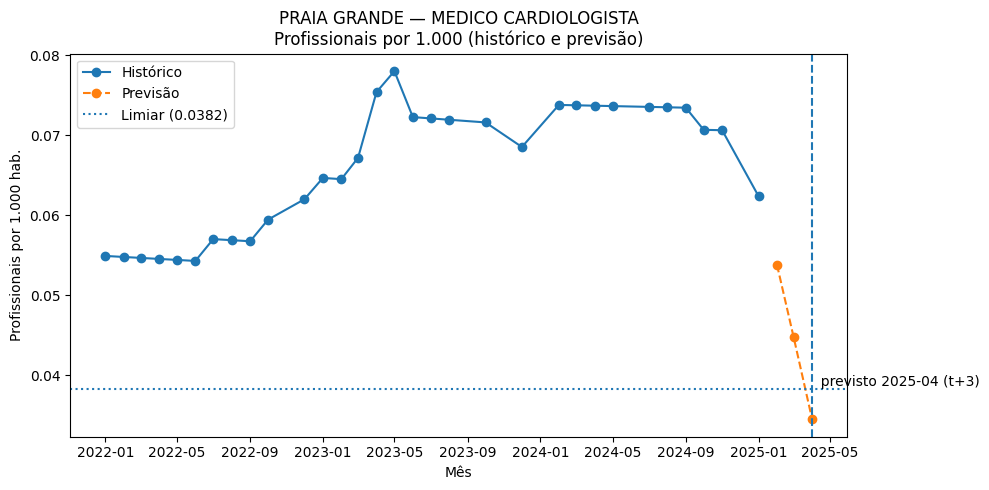

Nível atual: 0.0624 | Limiar: 0.0382 | Gap: 0.0000 por 1.000 | Profissionais faltantes (estimado): 0


In [150]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# caso não exista um mapa de limiar por especialidade, cria um pelo Q25 global
if "thresh_by_prof" not in globals():
    thresh_by_prof = (
        df_mais_100k.groupby("DS_ATIVIDADE_PROFISSIONAL")["PROFISSIONAIS_POR_1000"]
        .quantile(0.25)
        .to_dict()
    )
if "THRESH_DEFAULT" not in globals():
    THRESH_DEFAULT = 1.50  # fallback absoluto (ajuste se quiser)

def plot_city_specialty_trajectory(MUNI: str, PROF: str, horizon: int = 12):
    # filtra e ordena
    gdf = (df_mais_100k[(df_mais_100k["NO_MUNICIPIO"]==MUNI) &
                        (df_mais_100k["DS_ATIVIDADE_PROFISSIONAL"]==PROF)]
           .sort_values(["YYYY","MM"])
           .copy())
    if gdf.empty:
        print("Sem dados para esse município×especialidade.")
        return

    # limiar da especialidade (ou fallback)
    thr = float(thresh_by_prof.get(PROF, THRESH_DEFAULT))

    # previsão multi-passo e momento do cruzamento
    res = hitting_time_for_group(gdf, model, thresh=thr, H=horizon, features=FEATURES)

    # série histórica
    dates_hist = pd.to_datetime(
        gdf["YYYY"].astype(int).astype(str) + gdf["MM"].astype(int).astype(str).str.zfill(2),
        format="%Y%m"
    )
    y_hist = gdf["PROFISSIONAIS_POR_1000"].astype(float).to_numpy()

    # figura única (uma plotagem)
    plt.figure(figsize=(10,5))
    plt.plot(dates_hist, y_hist, marker="o", label="Histórico")

    # trajetória prevista (se houver)
    traj = res.get("traj", [])
    if traj:
        tf = pd.DataFrame(traj)
        dates_f = pd.to_datetime(
            tf["YYYY"].astype(int).astype(str) + tf["MM"].astype(int).astype(str).str.zfill(2),
            format="%Y%m"
        )
        plt.plot(dates_f, tf["yhat"], marker="o", linestyle="--", label="Previsão")

    # limiar horizontal
    plt.axhline(thr, linestyle=":", label=f"Limiar ({thr:.4f})")

    # marcos de cruzamento
    if res.get("hit"):
        if res.get("status") == "already_below":
            dt_hit = dates_hist.iloc[-1]
            msg = "já abaixo (t)"
        else:
            dt_hit = pd.Timestamp(int(res["YYYY"]), int(res["MM"]), 1)
            msg = f"previsto {dt_hit.strftime('%Y-%m')} (t+{res['horizon_months']})"
        plt.axvline(dt_hit, linestyle="--")
        plt.text(dt_hit, thr, "  " + msg, va="bottom")

    # título/rotulagem
    plt.title(f"{MUNI} — {PROF}\nProfissionais por 1.000 (histórico e previsão)")
    plt.xlabel("Mês")
    plt.ylabel("Profissionais por 1.000 hab.")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (opcional) imprime gap atual e estimativa de profissionais faltantes
    y_t = float(y_hist[-1])
    gap = max(thr - y_t, 0.0)
    pop_last = (gdf["POPULACAO_MENSAL"].dropna().iloc[-1]
                if "POPULACAO_MENSAL" in gdf.columns and gdf["POPULACAO_MENSAL"].notna().any()
                else np.nan)
    faltam = (np.ceil(gap * pop_last / 1000.0).astype(int) if pd.notna(pop_last) else None)
    print(f"Nível atual: {y_t:.4f} | Limiar: {thr:.4f} | Gap: {gap:.4f} por 1.000"
          + (f" | Profissionais faltantes (estimado): {faltam}" if faltam is not None else ""))

# EXEMPLO DE USO:
plot_city_specialty_trajectory("PRAIA GRANDE", "MEDICO CARDIOLOGISTA", horizon=12)


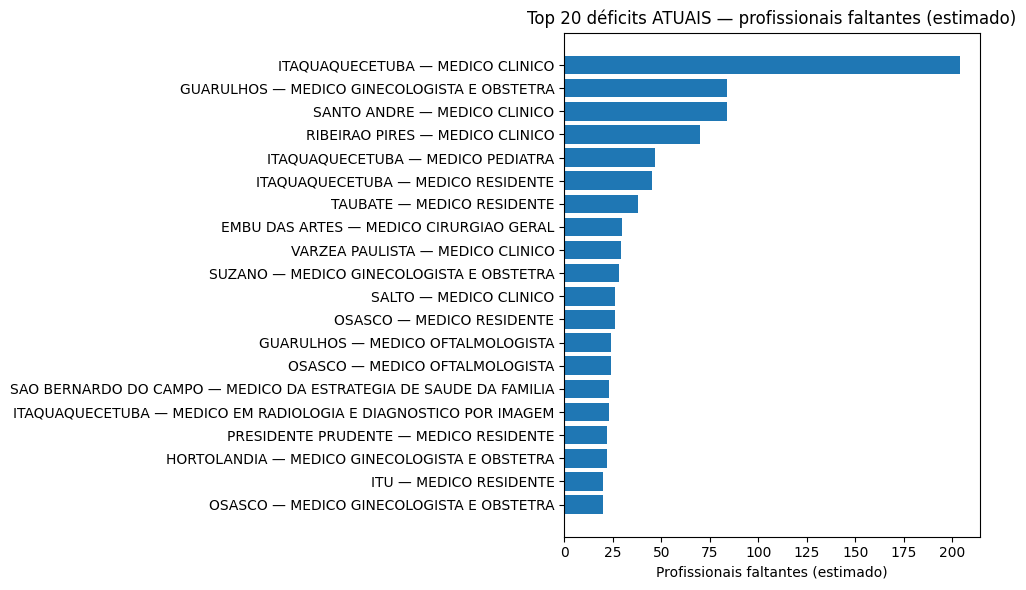

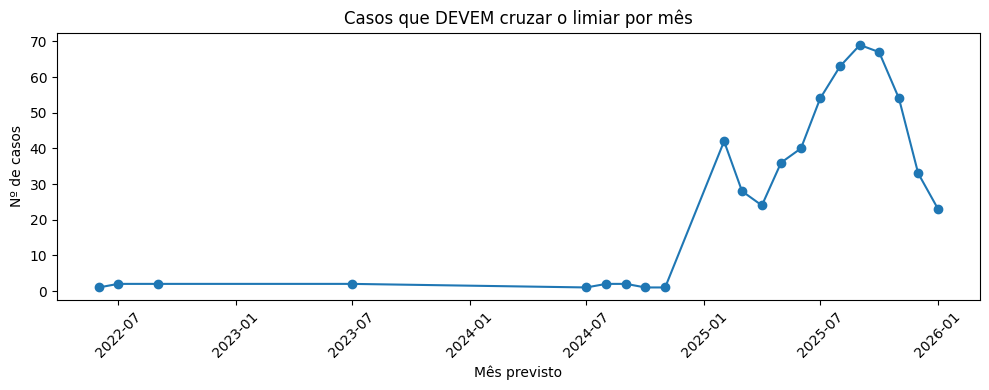

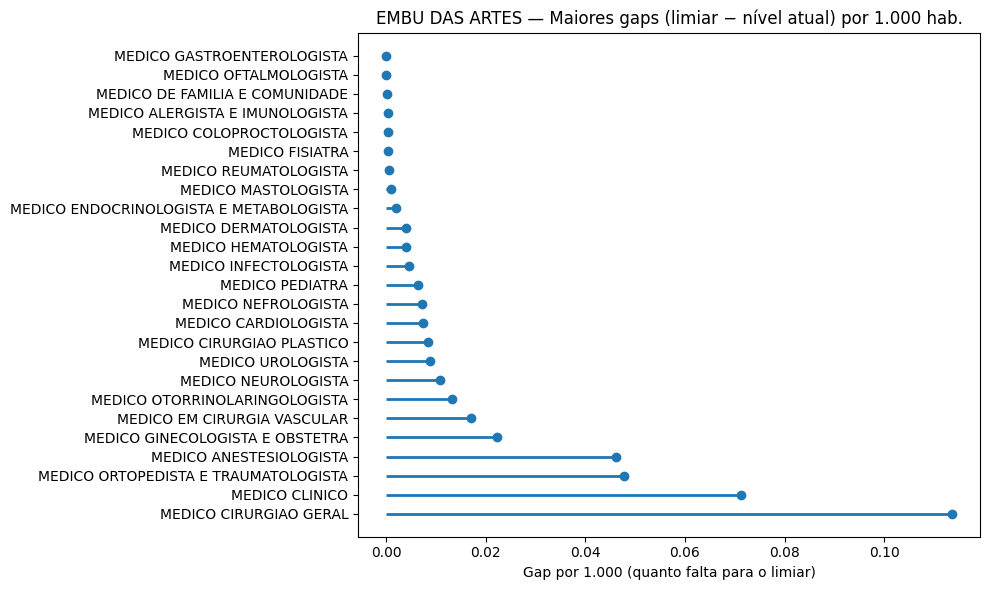

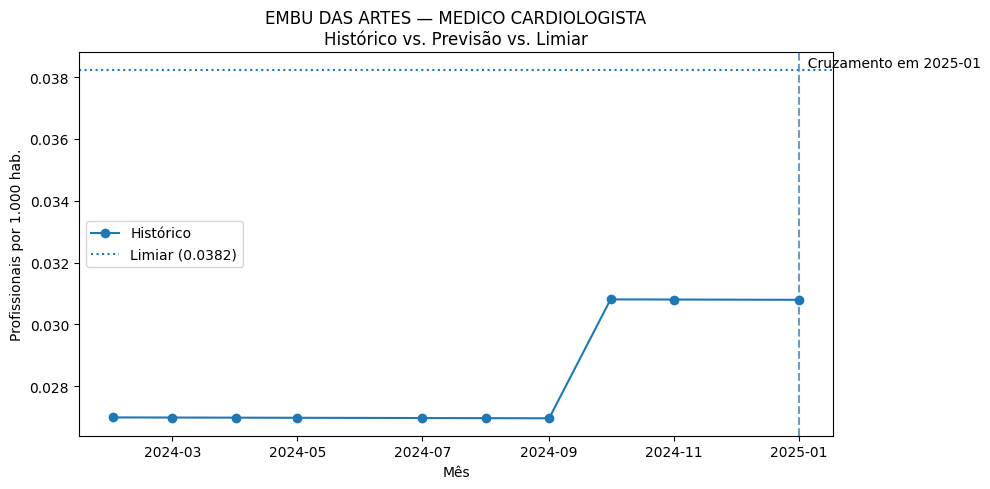

In [126]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) Pré-cálculos úteis (se ainda não tiver no df_when)
#    - data_prevista
#    - gap (quanto falta p/ bater limiar)
#    - estimativa de "profissionais faltantes" (usa POPULACAO_MENSAL do último mês)
# ------------------------------------------------------------
df_when = df_when.copy()

df_when["data_prevista"] = pd.to_datetime(
    df_when["YYYY_prev"].fillna(0).astype(int).astype(str) +
    df_when["MM_prev"].fillna(1).astype(int).astype(str).str.zfill(2),
    format="%Y%m", errors="coerce"
)

df_when["gap_por_1000"] = (df_when["limiar_usado"] - df_when["PROFISSIONAIS_POR_1000"]).clip(lower=0)

# POPULACAO_MENSAL do último mês por município×profissão
pop_last = (df_mais_100k.sort_values(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL","YYYY","MM"])
                      .groupby(["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"], as_index=False)
                      .tail(1)[["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL","POPULACAO_MENSAL"]])

df_when = df_when.merge(pop_last, on=["CO_MUNICIPIO_SEM_DIGITO","DS_ATIVIDADE_PROFISSIONAL"], how="left")
df_when["faltam_profissionais"] = np.ceil(df_when["gap_por_1000"] * df_when["POPULACAO_MENSAL"] / 1000).fillna(0).astype("Int64")

# ------------------------------------------------------------
# 1) RANKING — Top N “já abaixo” (déficit atual, ordenado por faltam_profissionais)
# ------------------------------------------------------------
N = 20
d1 = (df_when[df_when["status"]=="already_below"]
      .copy()
      .assign(label=lambda d: d["NO_MUNICIPIO"].fillna(d["CO_MUNICIPIO_SEM_DIGITO"].astype(str)) + " — " + d["DS_ATIVIDADE_PROFISSIONAL"])
      .sort_values("faltam_profissionais", ascending=False)
      .head(N))

plt.figure(figsize=(10, 6))
plt.barh(d1["label"], d1["faltam_profissionais"])
plt.gca().invert_yaxis()
plt.title(f"Top {len(d1)} déficits ATUAIS — profissionais faltantes (estimado)")
plt.xlabel("Profissionais faltantes (estimado)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2) CRONOGRAMA — Quantos casos devem cruzar o limiar por mês
# ------------------------------------------------------------
d2 = df_when[df_when["status"]=="forecast_hit"].copy()
if not d2.empty:
    counts = d2["data_prevista"].value_counts().sort_index()
    plt.figure(figsize=(10, 4))
    plt.plot(counts.index, counts.values, marker="o")
    plt.title("Casos que DEVEM cruzar o limiar por mês")
    plt.ylabel("Nº de casos")
    plt.xlabel("Mês previsto")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 3) MUNICÍPIO — “lollipop” dos maiores gaps por especialidade (escolha um município)
# ------------------------------------------------------------
MUNI = "EMBU DAS ARTES"   # <<< troque aqui
d3 = (df_when[df_when["NO_MUNICIPIO"]==MUNI]
      .copy()
      .assign(gap=lambda d: d["gap_por_1000"])
      .sort_values("gap", ascending=False)
      .head(25))

plt.figure(figsize=(10, 6))
y = np.arange(len(d3))
plt.hlines(y=y, xmin=0, xmax=d3["gap"], linewidth=2)
plt.plot(d3["gap"], y, "o")
plt.yticks(y, d3["DS_ATIVIDADE_PROFISSIONAL"])
plt.title(f"{MUNI} — Maiores gaps (limiar − nível atual) por 1.000 hab.")
plt.xlabel("Gap por 1.000 (quanto falta para o limiar)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4) TRAJETÓRIA — histórico vs. previsão vs. limiar (um município×especialidade)
#    Usa a função 'hitting_time_for_group' que você já tem.
# ------------------------------------------------------------
PROF = "MEDICO CARDIOLOGISTA"  # <<< troque aqui
mask = (df_mais_100k["NO_MUNICIPIO"]==MUNI) & (df_mais_100k["DS_ATIVIDADE_PROFISSIONAL"]==PROF)
gdf = df_mais_100k.loc[mask].sort_values(["YYYY","MM"])

# limiar por especialidade (do mapa que criamos antes) ou default
thr = float(thresh_by_prof.get(PROF, THRESH_DEFAULT))

res = hitting_time_for_group(gdf, model, thr, H=12, features=FEATURES)

# histórico
dates_hist = pd.to_datetime(gdf["YYYY"].astype(int).astype(str) + gdf["MM"].astype(int).astype(str).str.zfill(2), format="%Y%m")
plt.figure(figsize=(10, 5))
plt.plot(dates_hist, gdf["PROFISSIONAIS_POR_1000"], marker="o", label="Histórico")

# previsão (se houver)
traj = res.get("traj", [])
if traj:
    tf = pd.DataFrame(traj)
    dates_f = pd.to_datetime(tf["YYYY"].astype(int).astype(str) + tf["MM"].astype(int).astype(str).str.zfill(2), format="%Y%m")
    plt.plot(dates_f, tf["yhat"], marker="o", linestyle="--", label="Previsão")

# limiar
plt.axhline(thr, linestyle=":", label=f"Limiar ({thr:.4f})")

# info visual do cruzamento
if res.get("hit"):
    dt_hit = pd.Timestamp(int(res["YYYY"]), int(res["MM"]), 1)
    plt.axvline(dt_hit, linestyle="--", alpha=0.7)
    plt.text(dt_hit, thr, f"  Cruzamento em {dt_hit.strftime('%Y-%m')}", va="bottom")

plt.title(f"{MUNI} — {PROF}\nHistórico vs. Previsão vs. Limiar")
plt.xlabel("Mês")
plt.ylabel("Profissionais por 1.000 hab.")
plt.legend()
plt.tight_layout()
plt.show()
